In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from pandas.tseries.offsets import MonthEnd
import sys 
_HOME_ = "/mnt/d"
import plotting 
import modify_dataset
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import matplotlib.patches as mpatches
from matplotlib import colors
from scipy.stats import entropy

# Basics variables and parameters

In [2]:
phyto_abundances = pd.read_csv(_HOME_ + "/PHD/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [3]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [4]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [5]:
taxonomic_tree = pd.read_excel(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [6]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [7]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [8]:
transects_info = pd.read_csv("/mnt/d/PHD/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [9]:
def Pielou_evenness(data): 
    if data.size == 1: 
        return 0
    H = entropy(data, base = 10)
    H_max = np.log10(len(data))
    return H / H_max

In [10]:
def Simpson_diversity(data): 
    if data.size == 1: 
        return 1
    return -np.log(1 / np.square(np.sum(data)) * np.sum(np.square(data)))

In [11]:
def Renyi_entropy(data, alpha): 
    if data.size == 1: 
        return 1
    if alpha == 0: 
        return np.log(np.unique(data).size)
    if alpha == 1: 
        return entropy(data)
    if alpha == 2: 
        return Simpson_diversity(data)
    if alpha == "inf": 
        return -np.log(np.max(data / np.sum(data)))

## taxa selection

In [12]:
relevant_samples = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"], observed=True).agg({"Taxon" : "count", "Num_cell_l" : "sum"}).query("Taxon > 5 or Num_cell_l > 1000").index

In [14]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").query("Class == 'nan'").groupby("Taxon").agg(
    count = ("Taxon", "count"),
    abund = ("Num_cell_l", "sum")
)

count         abund
Taxon                               
Bacillariophyta     56  1.089579e+05
Chlorophyta        156  1.928183e+06
Flagellates         82  2.156914e+06
Haptophyta           1  1.507964e+02
Noctilucea           9  8.000000e+02
Non flagellates     10  4.373097e+03

In [13]:
higher_than_class = ['Other phytoplankton', "Haptophyta", "Noctilucea", "Non flagellates"]

In [14]:
relevant_taxa = phyto_abund_simplified.query("Taxon not in @higher_than_class").groupby("Taxon").agg(
    count = ("id", "count"),
    abund = ("Num_cell_l", "sum")
).query("count >= 10 or abund >= 1000").index

In [17]:
### create site_taxa matrix
phyto_abund_simplified.set_index(["id", "Date"]).loc[relevant_samples].query("Taxon in @relevant_taxa").reset_index().pivot_table(index = ["Region", "id", "Date"], columns="Taxon", values = "Num_cell_l", fill_value=0).reset_index().to_csv(_HOME_ + "/PHD/ISPRA_20152017_Analysis/site_taxa_matrix.csv", index = False)

# Overall Richness level

In [12]:
# Create the directory if it doesn't exist
directory = "/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels"
if not os.path.exists(directory):
    os.makedirs(directory)

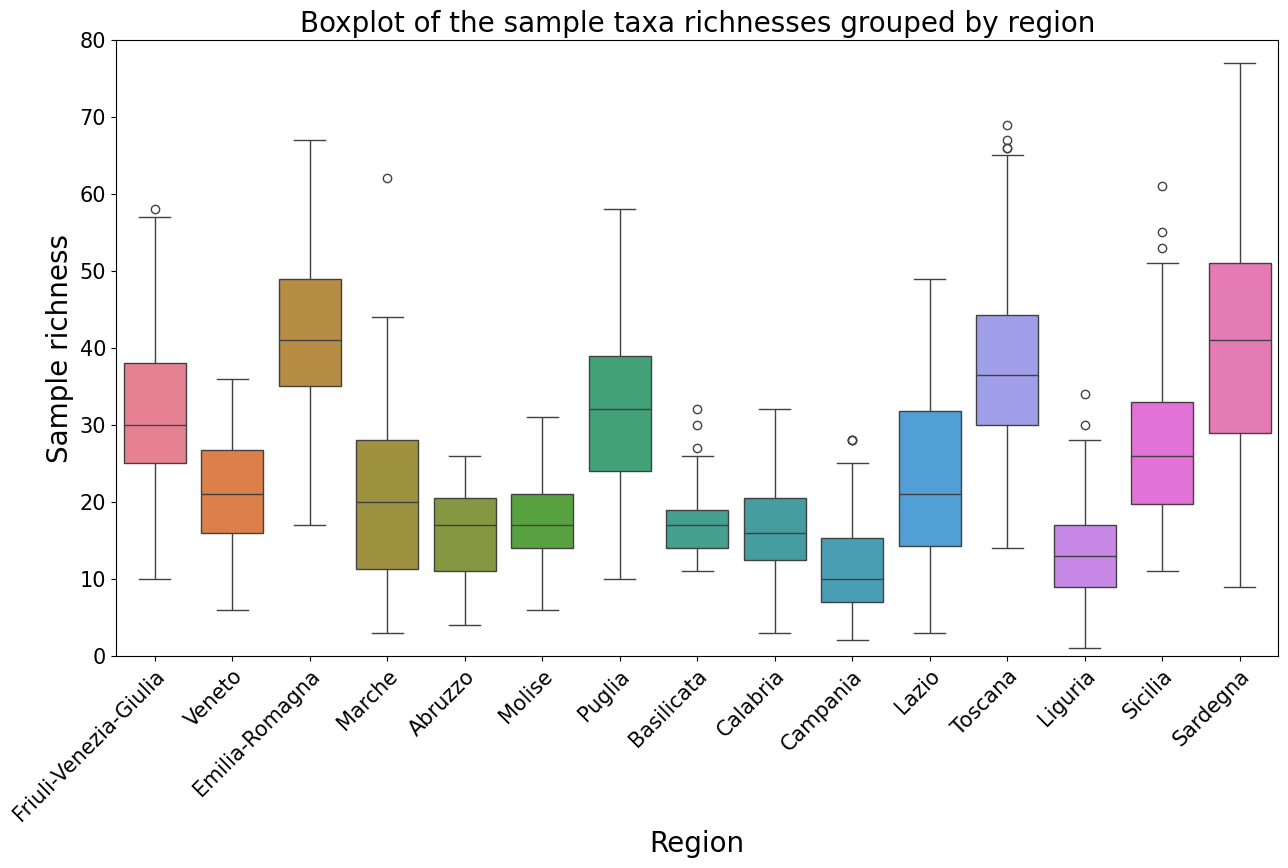

In [28]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"], observed = True).count().loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Taxon",
    hue = "Region",
    ax = ax
)
plt.title("Boxplot of the sample taxa richnesses grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Sample richness", fontsize = 20)
ax.set_ylim(0, 80)
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels/boxplot_richness_by_region.png",bbox_inches='tight')

/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


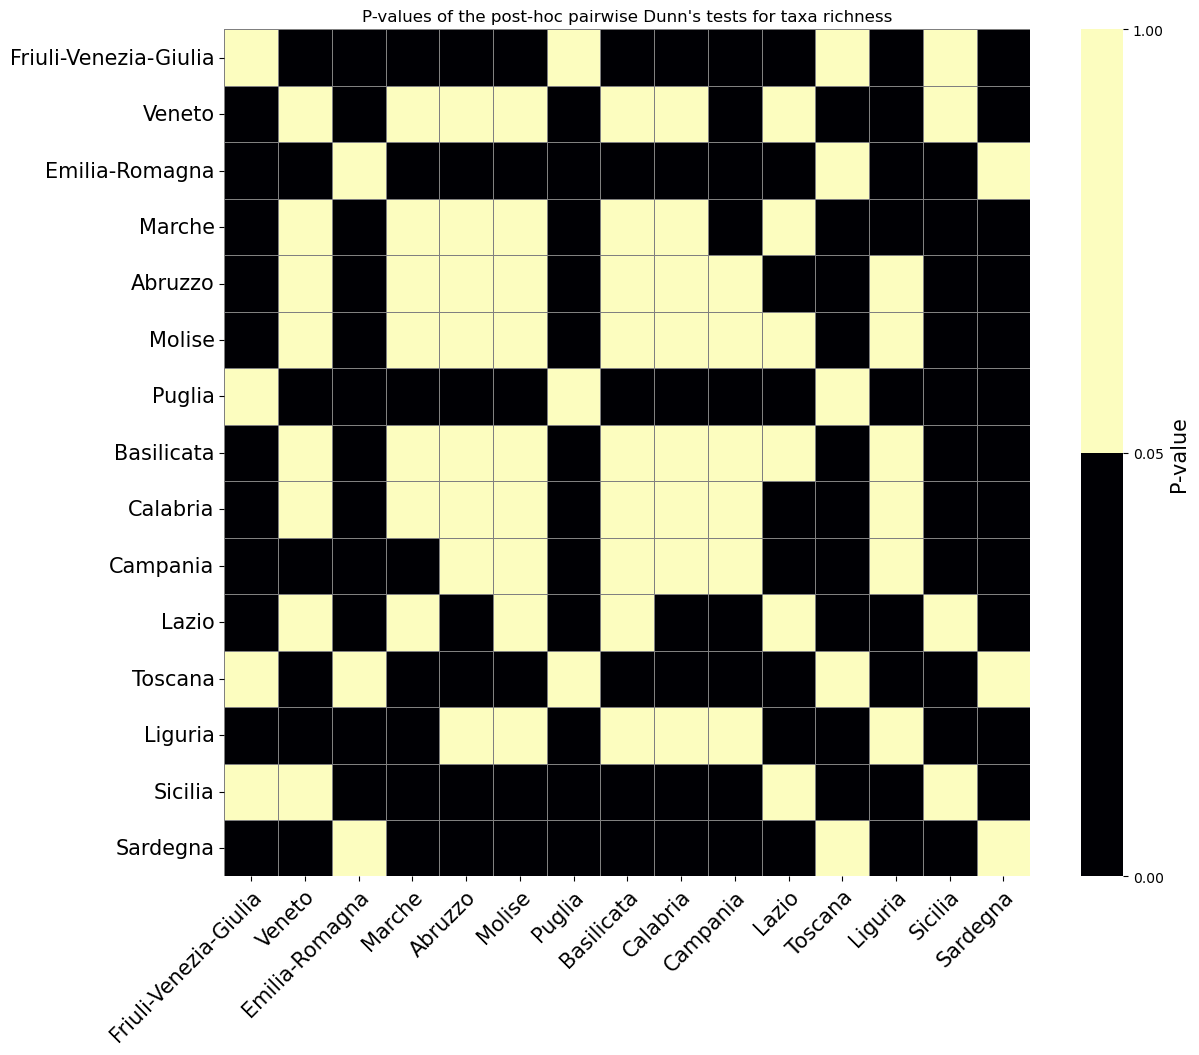

In [30]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
bounds = [0, 0.05, 1]
cm = cmaps.get_cmap("magma").resampled(len(bounds)-1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
richness_data = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"], observed=True).count().loc[ordered_regions, "Taxon"].reset_index()
p_values_richness = posthoc_dunn(richness_data, group_col="Region", val_col="Taxon", p_adjust="bonferroni")
p_values_richness = p_values_richness.loc[ordered_regions]

sns.heatmap(p_values_richness, ax=ax, cmap=cm, norm=norm, linewidth=0.5, linecolor="grey")
cbar = ax.collections[0].colorbar
cbar.set_label("P-value", size=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
plt.title("P-values of the post-hoc pairwise Dunn's tests for taxa richness")
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels/P_val_Dunn__region.png")

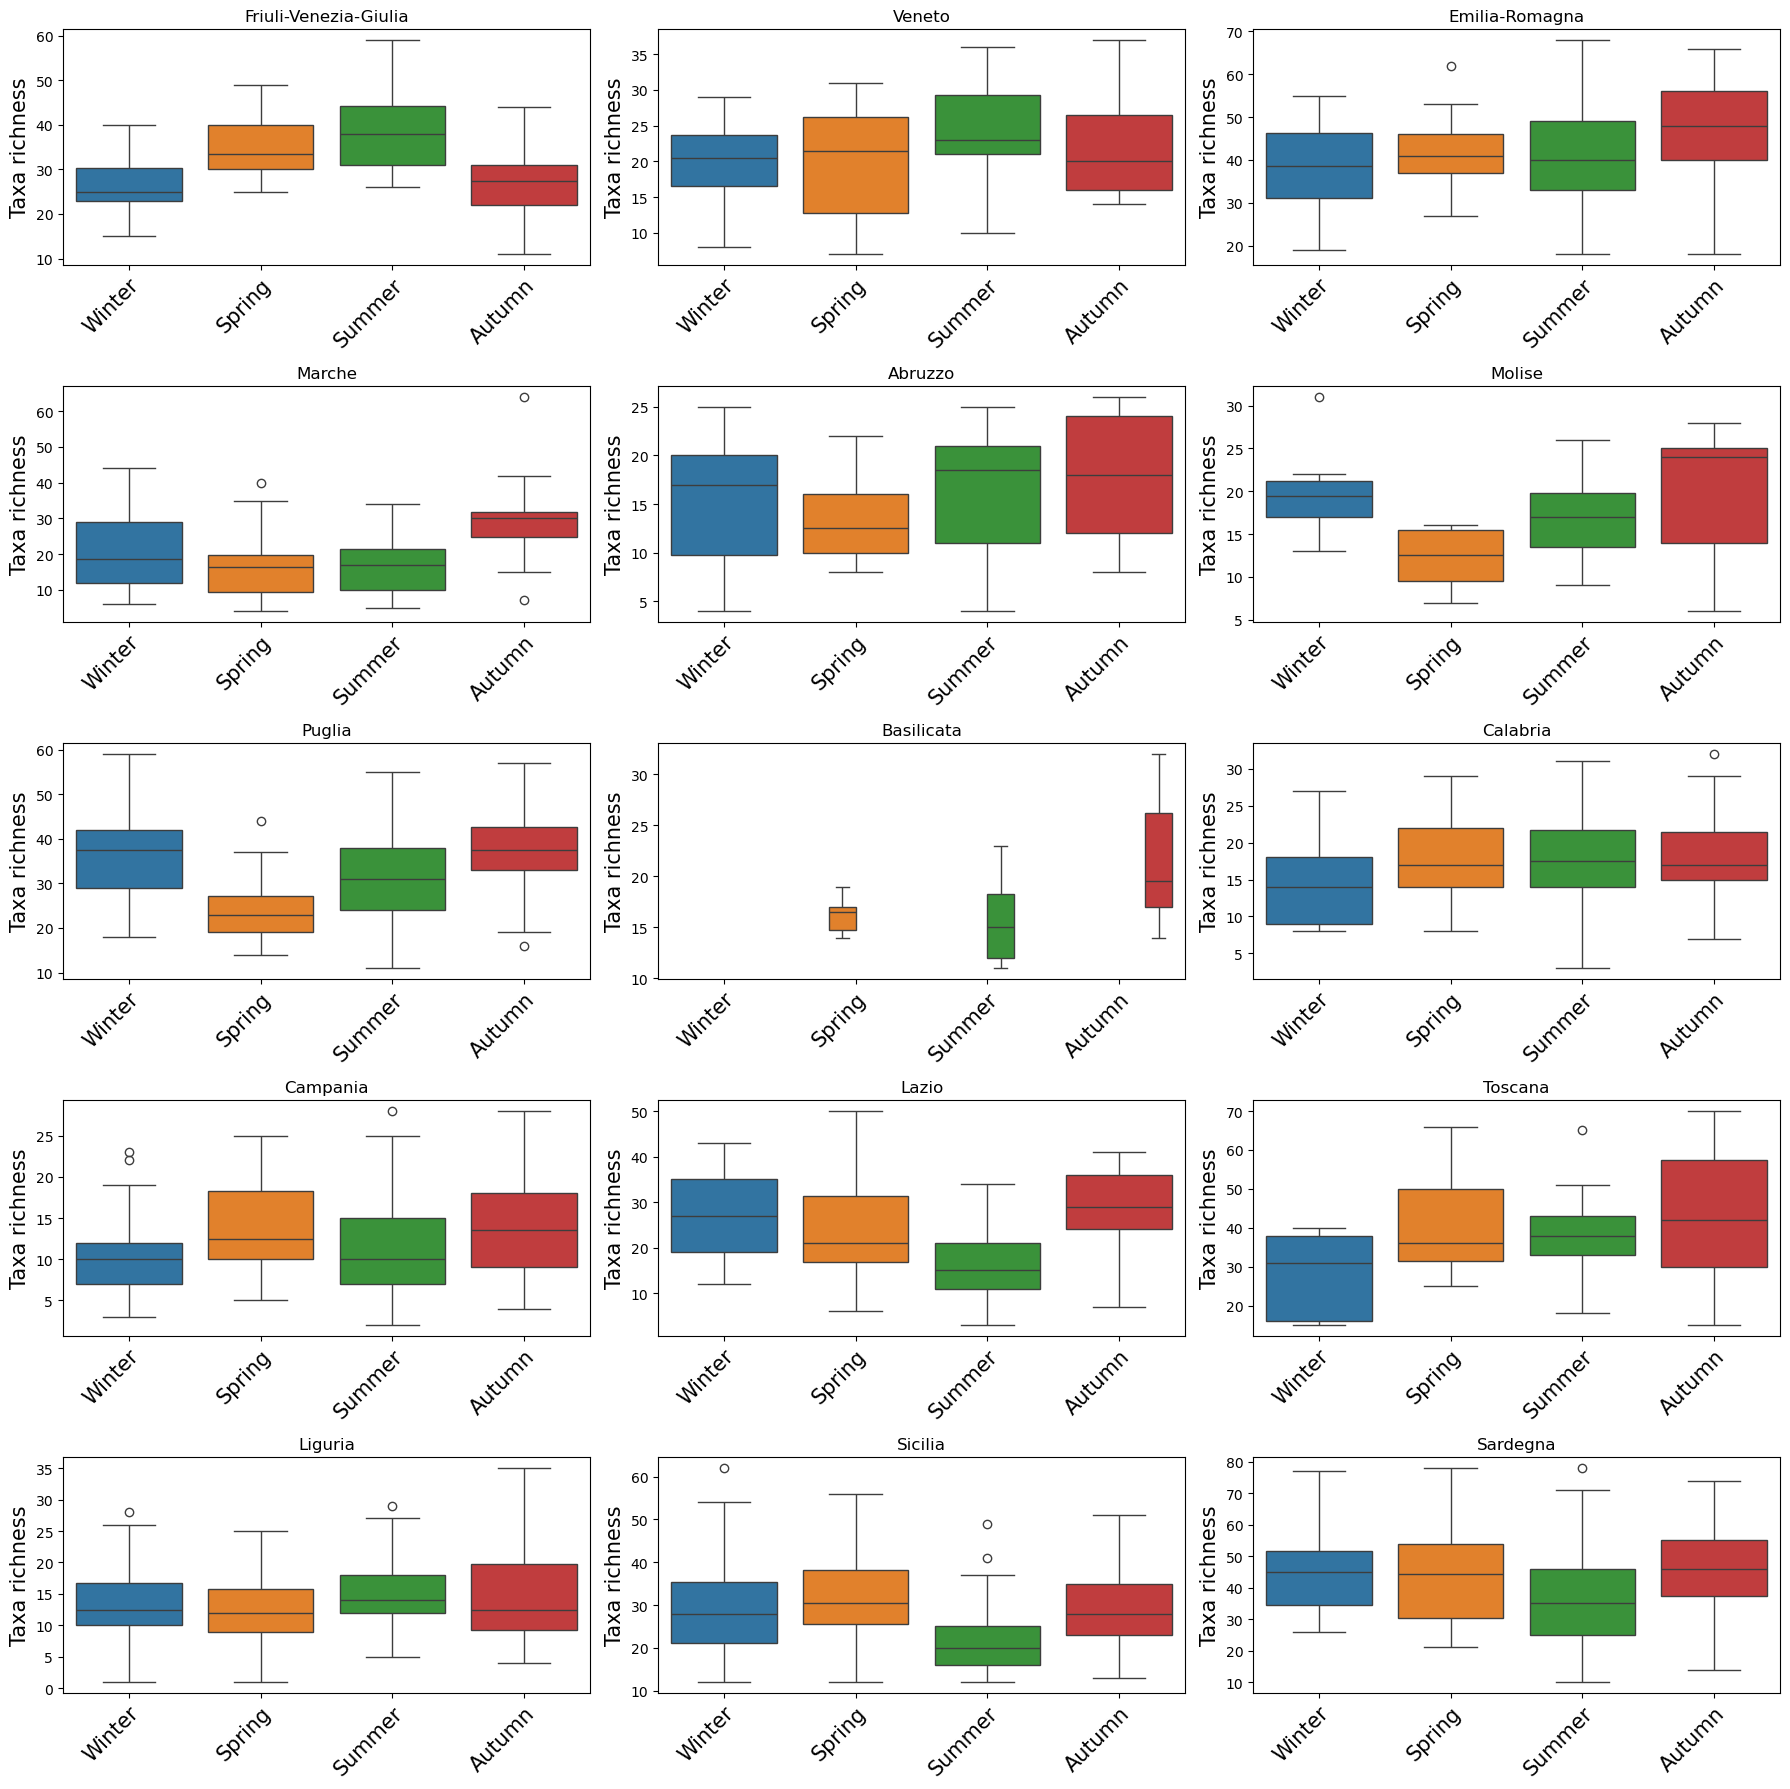

In [31]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, phyto_abund_simplified.groupby("Region", observed=True)):
    sns.boxplot(
        df_region.groupby(["id", "Date"], observed = True).agg({"Taxon" : "count", "Season" : "first"}).reset_index(),
        x = "Season",
        y = "Taxon",
        hue = "Season",
        ax = ax
    )
    n_samples = df_region.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(region)
    ax.set_xlabel("")
    ax.set_ylabel("Taxa richness", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels/boxplot_by_season_per_region.png")

# Overall evenness levels

In [32]:
# Create the directory if it doesn't exist
directory = "/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/Even_levels"
if not os.path.exists(directory):
    os.makedirs(directory)

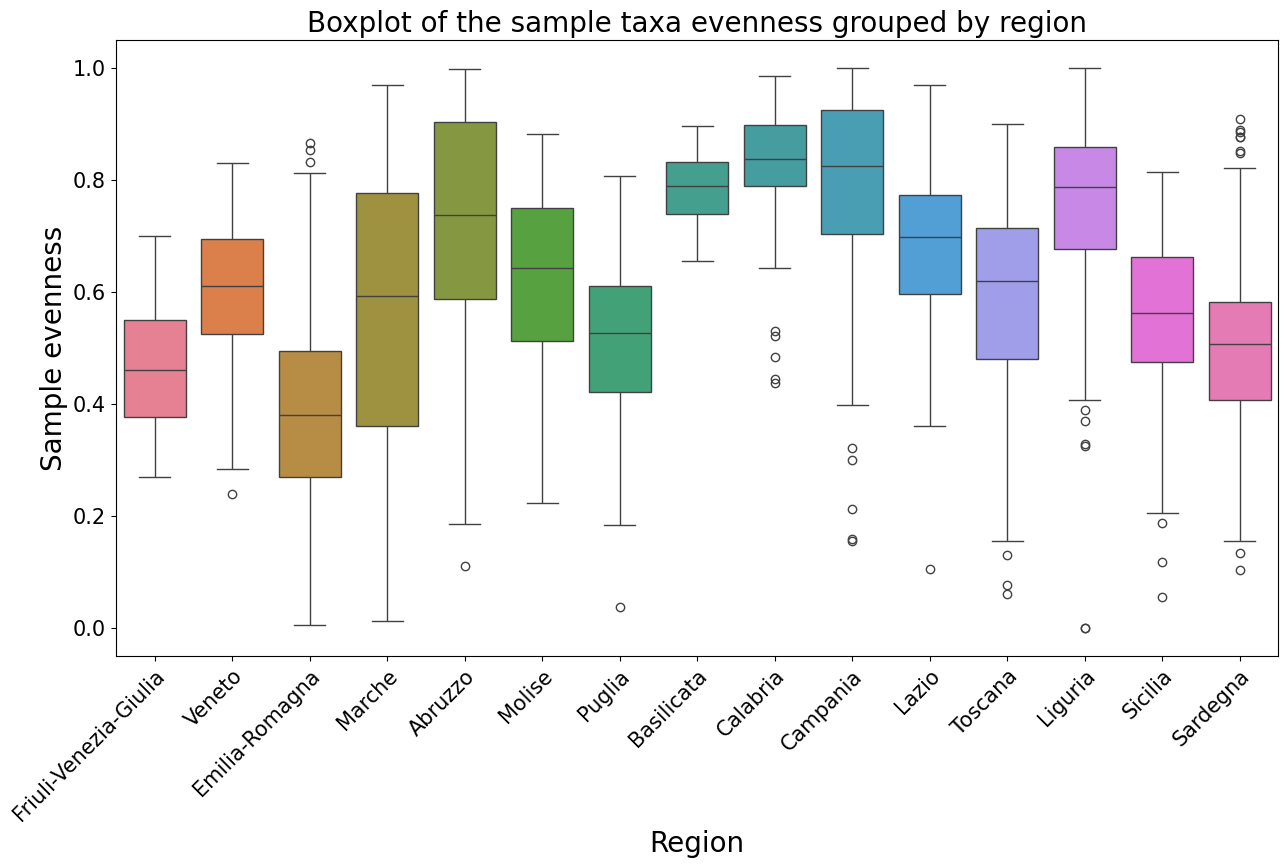

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = ax
)
plt.title("Boxplot of the sample taxa evenness grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Sample evenness", fontsize = 20)
ax.set_ylim(-0.05, 1.05)
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_evenness_by_region.png",bbox_inches='tight')

/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


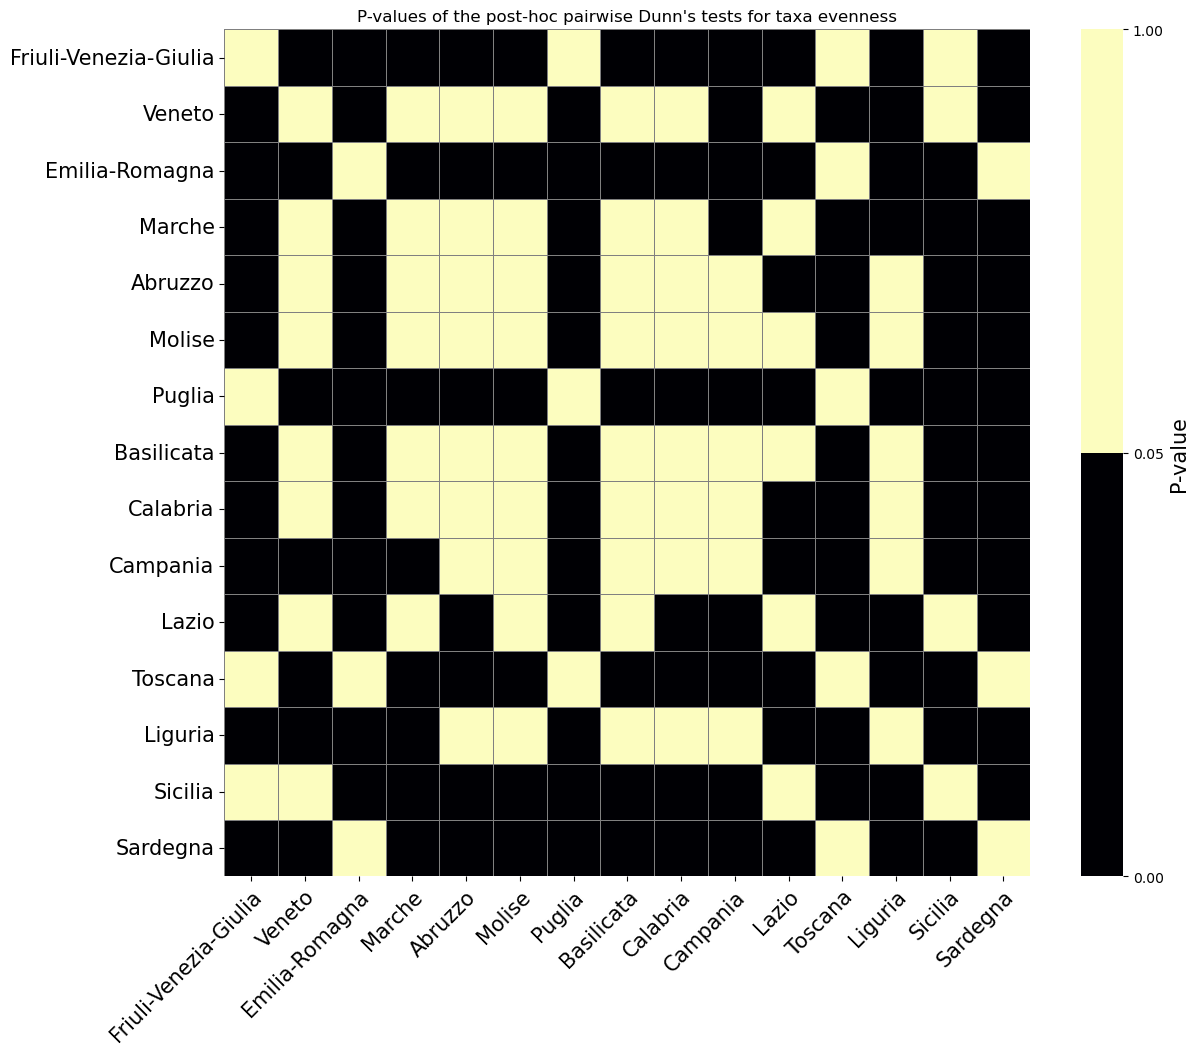

In [46]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
bounds = [0, 0.05, 1]
cm = cmaps.get_cmap("magma").resampled(len(bounds)-1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
evenness_data = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index()
p_values = posthoc_dunn(evenness_data, group_col="Region", val_col="Num_cell_l", p_adjust="bonferroni")
p_values = p_values.loc[ordered_regions]

sns.heatmap(p_values_richness, ax=ax, cmap=cm, norm=norm, linewidth=0.5, linecolor="grey")
cbar = ax.collections[0].colorbar
cbar.set_label("P-value", size=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
plt.title("P-values of the post-hoc pairwise Dunn's tests for taxa evenness")
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/P_val_Dunn__region.png")

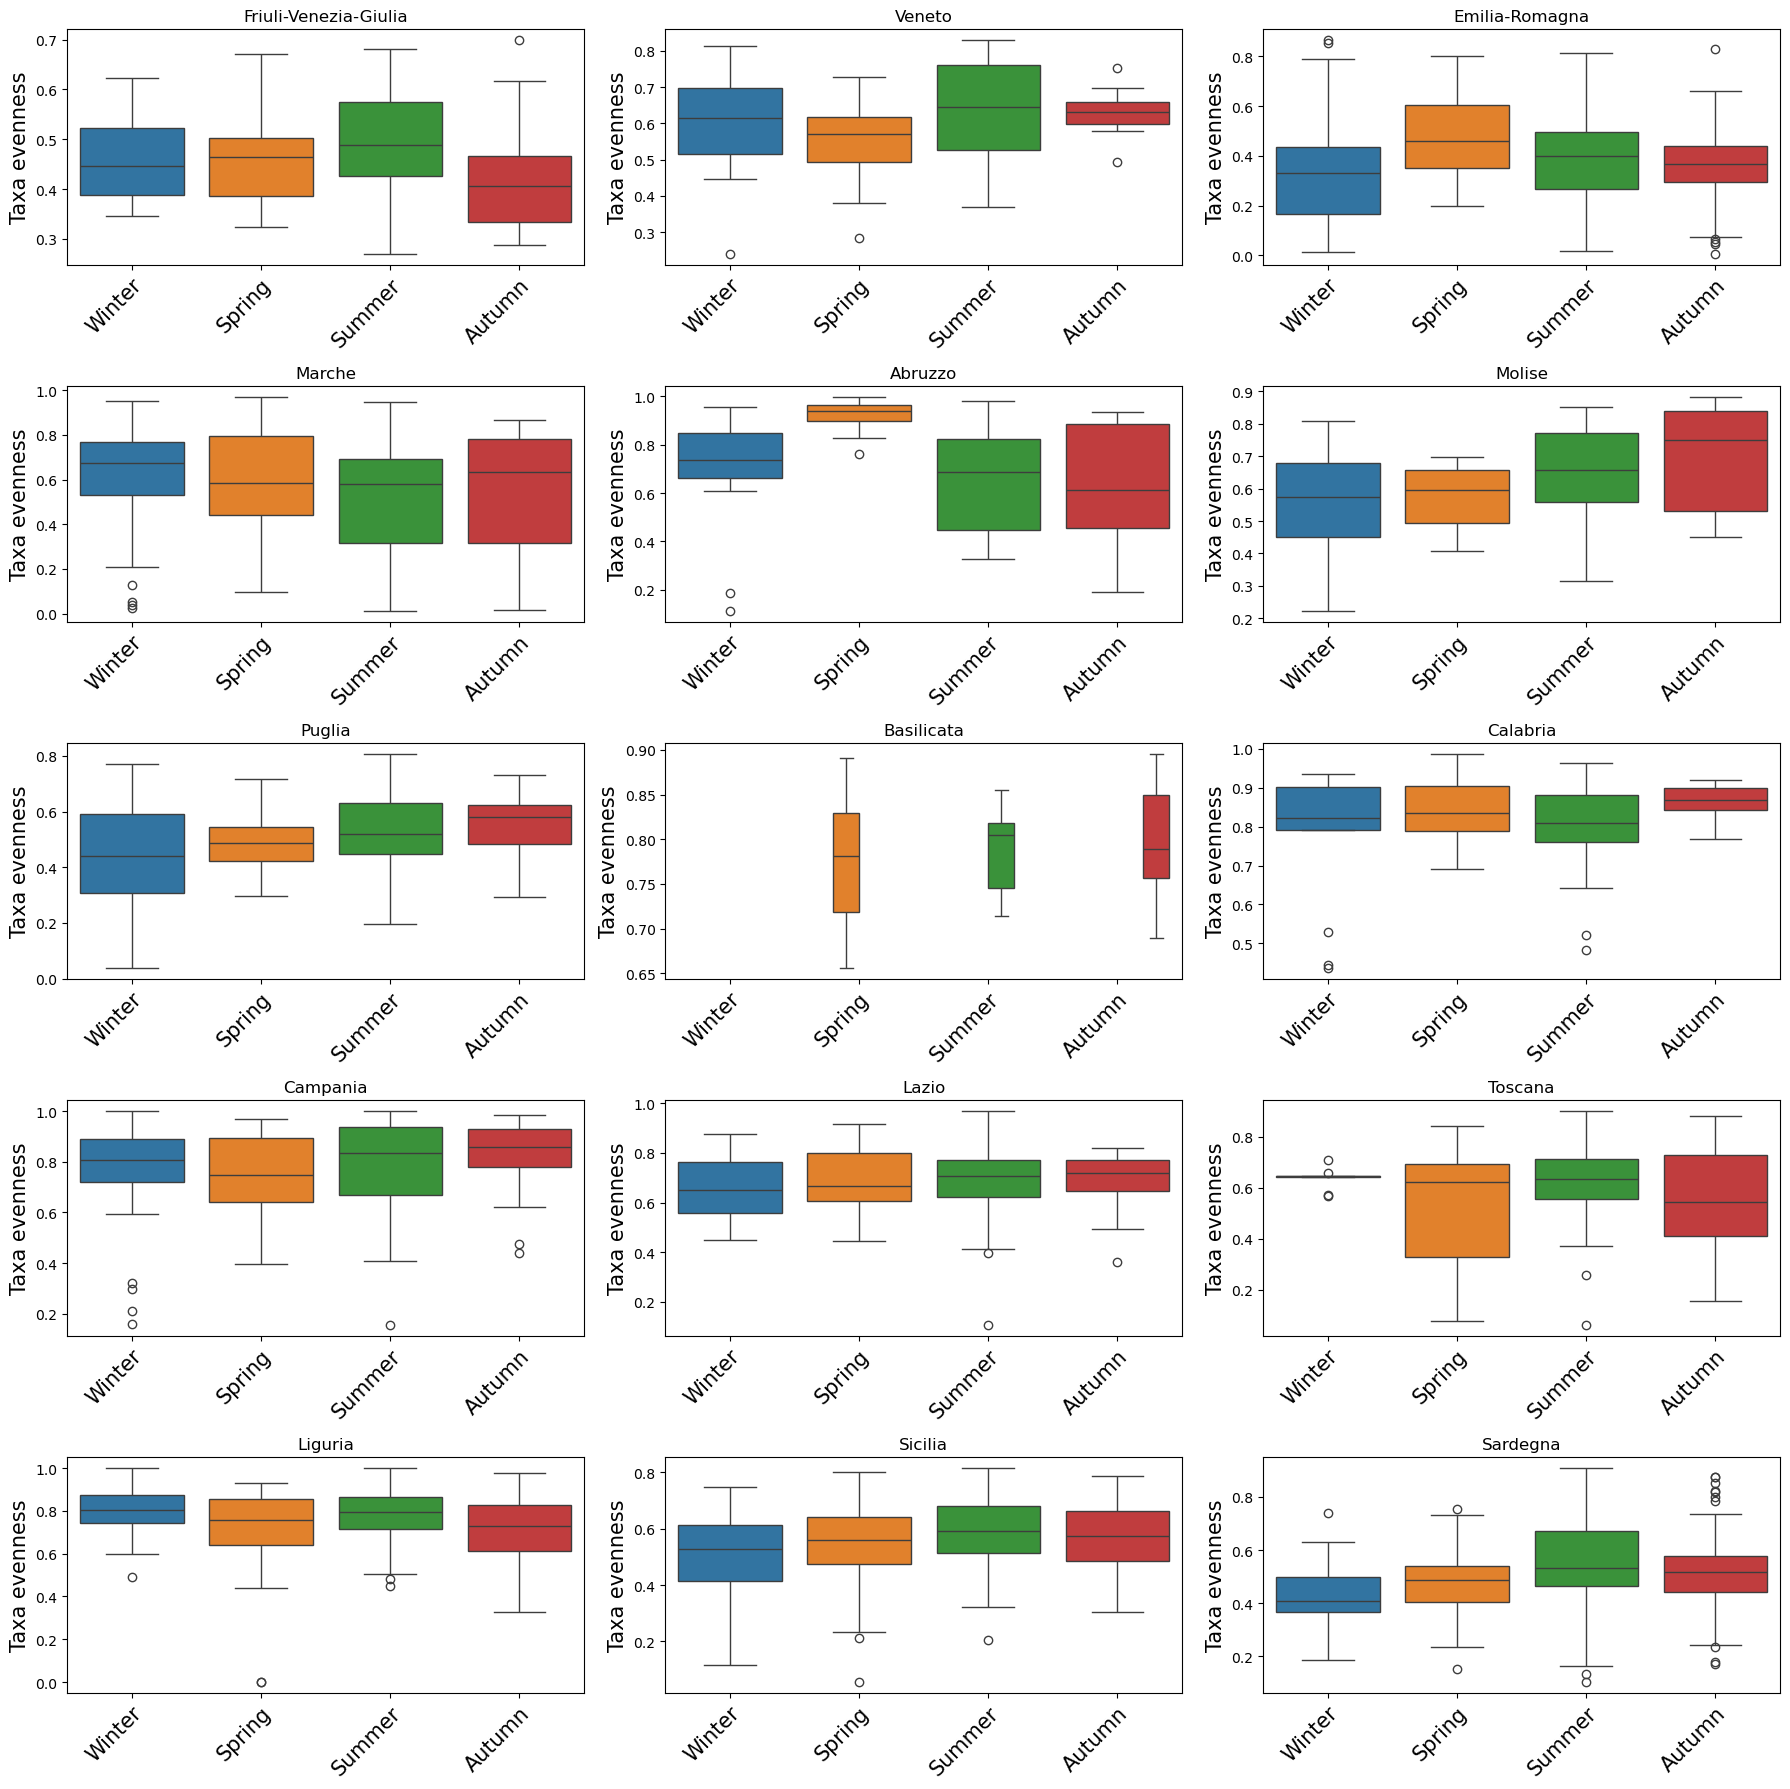

In [50]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Season", "Num_cell_l"]].groupby("Region", observed=True)):
    sns.boxplot(
        df_region.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : Pielou_evenness, "Season" : "first"}).reset_index(),
        x = "Season",
        y = "Num_cell_l",
        hue = "Season",
        ax = ax
    )
    n_samples = df_region.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(region)
    ax.set_xlabel("")
    ax.set_ylabel("Taxa evenness", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_by_season_per_region.png")

# corr. among species

In [96]:
species_spearman = phyto_abund_simplified.set_index(["id", "Date"]).loc[relevant_samples].query("Taxon in @relevant_taxa").pivot_table(index = ["id", "Date"], columns = "Taxon", values = "Num_cell_l", fill_value=0).corr("spearman")

In [97]:
np.fill_diagonal(species_spearman.values, np.nan)

<Axes: xlabel='Taxon', ylabel='Taxon'>

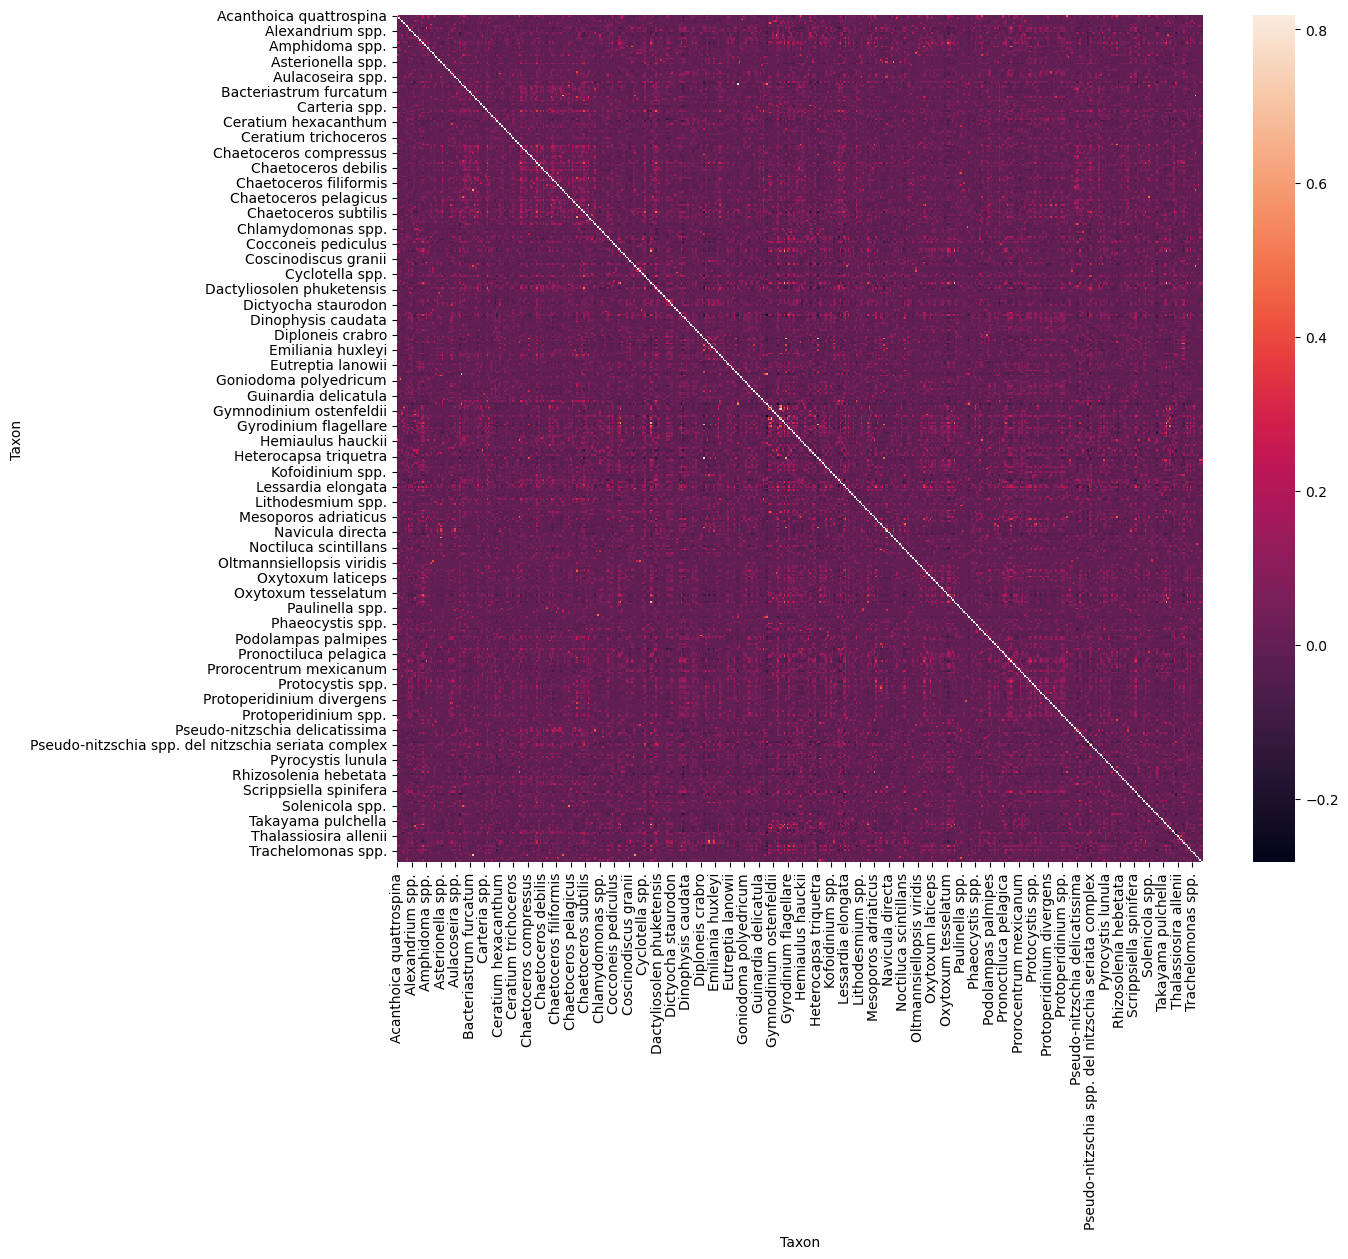

In [98]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
sns.heatmap(species_spearman, ax = ax)

In [26]:
phyto_abund_simplified.set_index(["id", "Date"]).loc[relevant_samples].pivot_table(index = ["id", "Date"], columns = "Taxon", values = "Num_cell_l", fill_value=0).loc[:, ["Eutreptiella marina", "Craspedotella pileolus"]]

Taxon                         Eutreptiella marina  Craspedotella pileolus
id                Date                                                   
0004-MS00200_TR03 2015-08-31                  0.0                     0.0
                  2015-10-31                  0.0                     0.0
                  2015-12-31                  0.0                     0.0
                  2016-01-31                  0.0                     0.0
                  2016-04-30                  0.0                     0.0
...                                           ...                     ...
VOL120            2017-02-28                  0.0                     0.0
                  2017-05-31                  0.0                     0.0
                  2017-07-31                  0.0                     0.0
                  2017-09-30                  0.0                     0.0
                  2017-11-30                  0.0                     0.0

[2183 rows x 2 columns]

In [24]:
species_spearman.unstack().sort_values(ascending=False).head(10)

Taxon                  Taxon                    
Eutreptiella marina    Craspedotella pileolus       1.0
Glenodinium spp.       Oxytoxum ovale               1.0
Oxytoxum ovale         Pyramimonas amylifera        1.0
Gomphonema parvulum    Cocconeis pediculus          1.0
Thalassiosira allenii  Nitzschia capitellata        1.0
Gomphonema parvulum    Thalassiosira weissflogii    1.0
Ophiaster spp.         Meringosphaera radians       1.0
Oxytoxum ovale         Glenodinium spp.             1.0
Pyramimonas amylifera  Oxytoxum ovale               1.0
Michaelsarsia elegans  Gyrodinium pellucidum        1.0
dtype: float64

# Renyi Entropy

In [177]:
Renyi = phyto_abund_simplified.query("Region == 'Abruzzo'").groupby(["Region", "Season", "id", "Date"], observed=True).agg(
    H_0 = pd.NamedAgg(column = "Taxon",  aggfunc= lambda x: Renyi_entropy(x, 0)), 
    H_1 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 1)), 
    H_2 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 2)), 
    H_inf = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, "inf"))
)#.reset_index()

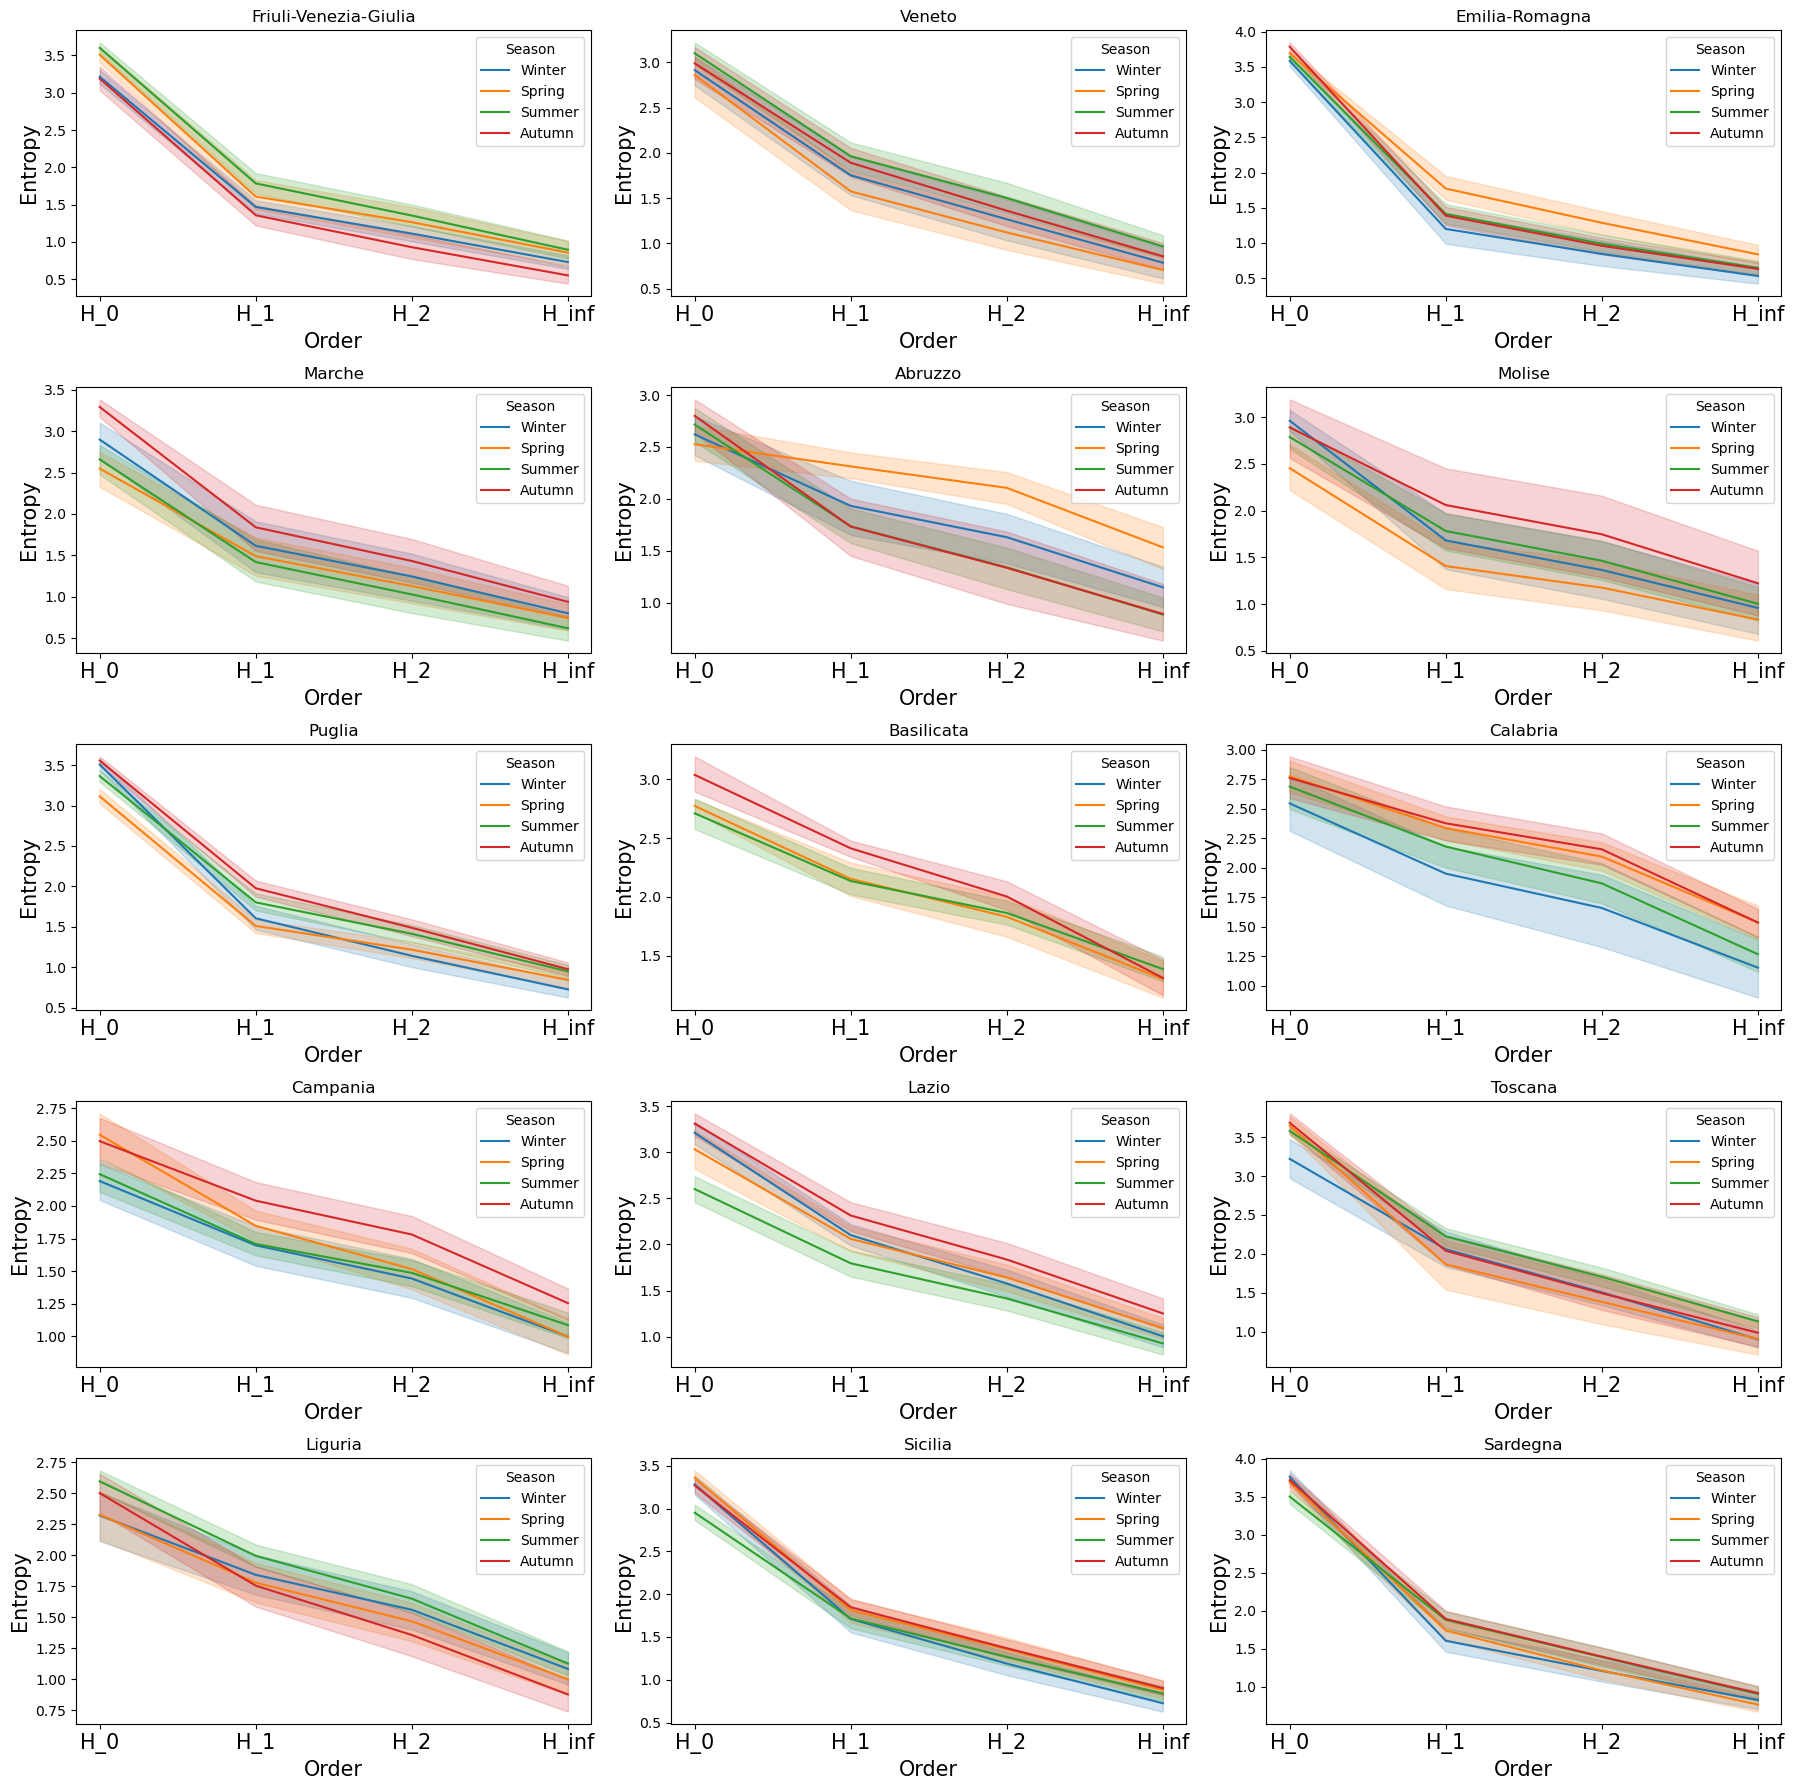

In [11]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Season", "Taxon", "Num_cell_l"]].groupby("Region", observed=True)):
    Renyi = df_region.groupby(["Region", "Season", "id", "Date"], observed=True).agg(
    H_0 = pd.NamedAgg(column = "Taxon",  aggfunc= lambda x: Renyi_entropy(x, 0)), 
    H_1 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 1)), 
    H_2 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 2)), 
    H_inf = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, "inf"))
    )
    Renyi.columns.name = "Order"
    Renyi = Renyi.stack()
    Renyi = Renyi.reset_index().rename(columns = {0 : "Entropy"})
    sns.lineplot(Renyi.reset_index(), x = "Order", y = "Entropy", hue = "Season", ax = ax)
    ax.set_title(region)
    ax.set_xlabel("Order", size = 15)
    ax.set_ylabel("Entropy", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_by_season_per_region.png")

# alpha div. along gradient

In [54]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").set_index("id" ).loc['ORO060',:].drop_duplicates("Date")#.sort_values("Date", ascending=False)

Region  Longitude  Latitude  Closest_coast Coast_dist       Date  \
id                                                                          
ORO060  Liguria     9.1044    44.226         11.112        mid 2015-08-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2015-09-30   
ORO060  Liguria     9.1044    44.226         11.112        mid 2015-11-30   
ORO060  Liguria     9.1044    44.226         11.112        mid 2016-01-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2016-03-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2016-05-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2016-07-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2016-09-30   
ORO060  Liguria     9.1044    44.226         11.112        mid 2016-12-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2017-02-28   
ORO060  Liguria     9.1044    44.226         11.112        mid 2017-05-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2017-07-31   
ORO060  Liguria     9.1044    44.226         11.112        mid 2017-09-30   
ORO060  Liguria     9.1044    44.226         11.112        mid 2017-12-31   

        Season_year  Season  Sample_depth              Class  \
id                                                             
ORO060  Summer-2015  Summer           0.5        Dinophyceae   
ORO060  Summer-2015  Summer           0.5        Dinophyceae   
ORO060  Autumn-2015  Autumn           0.5  Bacillariophyceae   
ORO060  Winter-2016  Winter           0.5  Bacillariophyceae   
ORO060  Winter-2016  Winter           0.5  Bacillariophyceae   
ORO060  Spring-2016  Spring           0.5  Bacillariophyceae   
ORO060  Summer-2016  Summer           0.5        Dinophyceae   
ORO060  Summer-2016  Summer           0.5        Dinophyceae   
ORO060  Autumn-2016  Autumn           0.5        Dinophyceae   
ORO060  Winter-2017  Winter           0.5        Dinophyceae   
ORO060  Spring-2017  Spring           0.5  Bacillariophyceae   
ORO060  Summer-2017  Summer           0.5  Bacillariophyceae   
ORO060  Summer-2017  Summer           0.5  Bacillariophyceae   
ORO060  Autumn-2017  Autumn           0.5  Bacillariophyceae   

                   Genus    Det_level                       Taxon  Num_cell_l  \
id                                                                              
ORO060         Achradina        Genus              Achradina spp.        20.0   
ORO060       Alexandrium        Genus            Alexandrium spp.        20.0   
ORO060               NaN  Higher cat.           Bacillariophyceae        60.0   
ORO060               NaN  Higher cat.           Bacillariophyceae       140.0   
ORO060               NaN  Higher cat.           Bacillariophyceae        20.0   
ORO060               NaN  Higher cat.           Bacillariophyceae        40.0   
ORO060          Ceratium      Species              Ceratium furca        80.0   
ORO060       Alexandrium      Species         Alexandrium minutum        20.0   
ORO060      Amphisolenia      Species      Amphisolenia bidentata        10.0   
ORO060       Alexandrium        Genus            Alexandrium spp.        80.0   
ORO060               NaN  Higher cat.           Bacillariophyceae        40.0   
ORO060               NaN  Higher cat.           Bacillariophyceae        60.0   
ORO060  Asterionellopsis      Species  Asterionellopsis glacialis      1520.0   
ORO060               NaN  Higher cat.           Bacillariophyceae       100.0   

                                               file_name   Transect  SeaDepth  
id                                                                             
ORO060  Modulo_1_20160530150113_ARPA_Liguria_Liguria.xls  PORTOFINO     909.0  
ORO060  Modulo_1_20160613153035_ARPA_Liguria_Liguria.xls  PORTOFINO     909.0  
ORO060  Modulo_1_20160613171241_ARPA_Liguria_Liguria.xls  PORTOFINO     909.0  
ORO060  Modulo_1_20161007095936_ARPA_Liguria_Liguria.x

In [65]:
Renyi = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").set_index(["id", "Date"]).loc[relevant_samples, ["Taxon", "Num_cell_l"]].groupby(["id", "Date"], observed=True).agg(
    H_0 = pd.NamedAgg(column = "Taxon",  aggfunc= lambda x: Renyi_entropy(x, 0)), 
    H_1 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 1)), 
    H_2 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 2)), 
    H_inf = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, "inf"))
)

In [78]:
Shannon = pd.merge(
    Renyi,
    phyto_abund_simplified[["id", "Longitude", "Latitude", "Region", "Date", "Season"]].drop_duplicates(),
    on = ["id", "Date"], 
    how = "left"
)

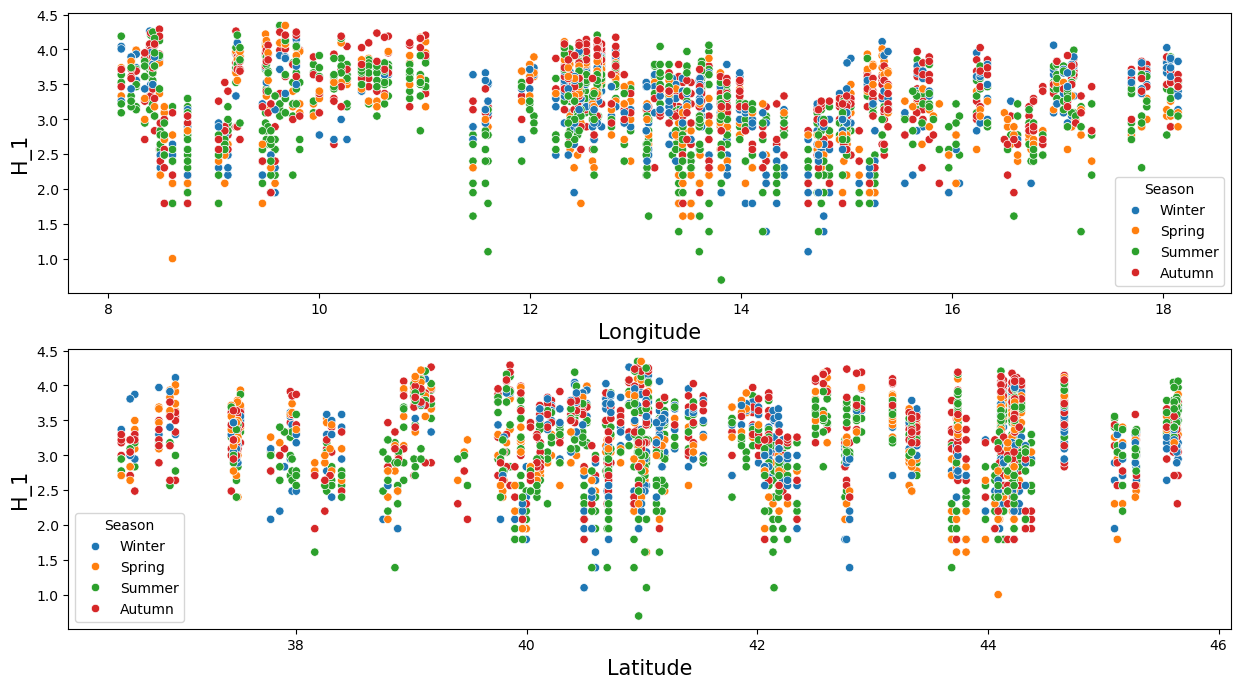

In [82]:
fig, axs = plt.subplots(2,1, figsize=(15, 8))
axs = axs.flatten()
for (ax, coord) in zip(axs, ["Longitude", "Latitude"]): 
    sns.scatterplot(Shannon, x = coord, y = "H_0", hue = "Season", ax = ax)
    ax.set_xlabel(coord, size = 15)
    ax.set_ylabel("H_1", size = 15) 
    #ax.legend().remove()

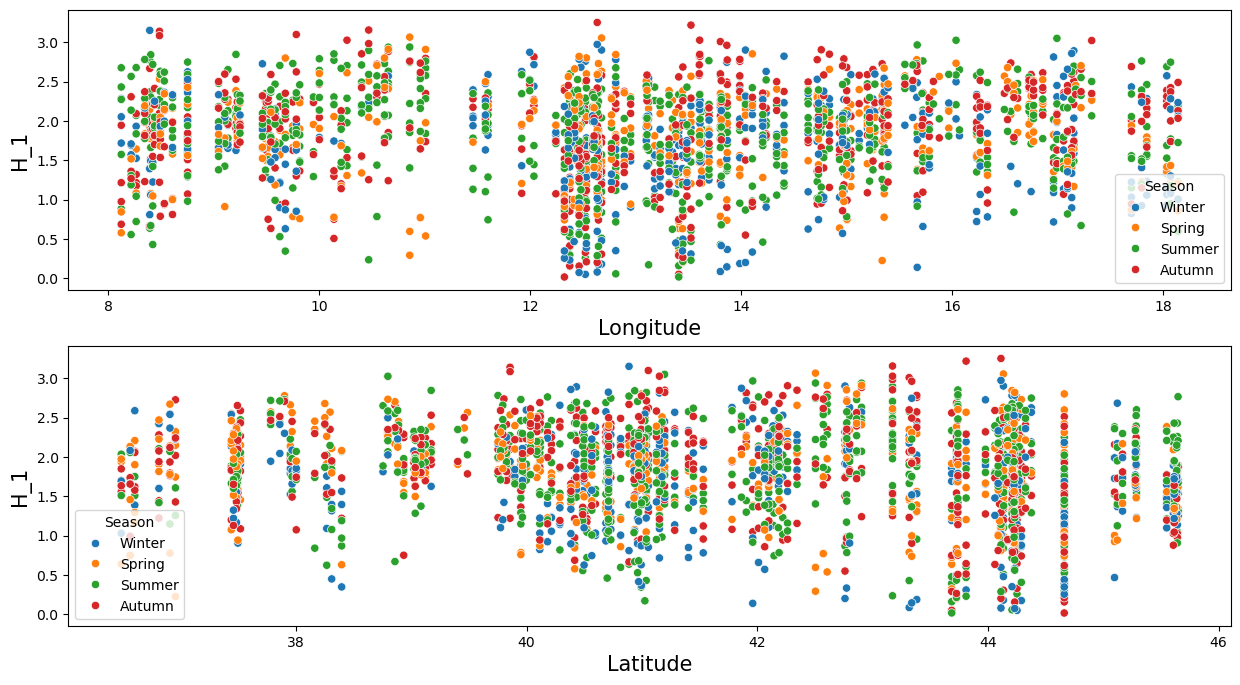

In [80]:
fig, axs = plt.subplots(2,1, figsize=(15, 8))
axs = axs.flatten()
for (ax, coord) in zip(axs, ["Longitude", "Latitude"]): 
    sns.scatterplot(Shannon, x = coord, y = "H_1", hue = "Season", ax = ax)
    ax.set_xlabel(coord, size = 15)
    ax.set_ylabel("H_1", size = 15) 
    #ax.legend().remove()

# creare sites X species dataset per region

In [187]:
phyto_abund_simplified.query("Region == 'Abruzzo'").query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Season", "Taxon", "Num_cell_l"]].pivot_table(index = ["Region", "Season", "id", "Date"], columns = "Taxon", values = "Num_cell_l").fillna(0)#.reset_index().groupby(["Region", "Season"]).agg(lambda x: Renyi_entropy(x, 1))

Taxon                                 Akashiwo sanguinea  Alexandrium minutum  \
Region  Season id         Date                                                  
Abruzzo Winter 1_ABR_GU04 2016-01-31                 0.0                  0.0   
                          2016-03-31                 0.0                  0.0   
                          2017-02-28                 0.0                  0.0   
                          2017-03-31                 0.0                120.0   
               1_ABR_GU05 2016-01-31                 0.0                  0.0   
...                                                  ...                  ...   
        Autumn 1_ABR_VA14 2017-12-31                 0.0                  0.0   
               1_ABR_VA15 2015-11-30                 0.0                  0.0   
                          2016-11-30                 0.0                  0.0   
                          2017-10-31                 0.0                  0.0   
                          2017-12-31                 0.0                  0.0   

Taxon                                 Alexandrium spp.  \
Region  Season id         Date                           
Abruzzo Winter 1_ABR_GU04 2016-01-31               0.0   
                          2016-03-31               0.0   
                          2017-02-28               0.0   
                          2017-03-31              80.0   
               1_ABR_GU05 2016-01-31               0.0   
...                                                ...   
        Autumn 1_ABR_VA14 2017-12-31               0.0   
               1_ABR_VA15 2015-11-30               0.0   
                          2016-11-30              40.0   
                          2017-10-31               0.0   
                          2017-12-31               0.0   

Taxon                                 Asterionellopsis glacialis  \
Region  Season id         Date                                     
Abruzzo Winter 1_ABR_GU04 2016-01-31                         0.0   
                          2016-03-31                         0.0   
                          2017-02-28                         0.0   
                          2017-03-31                         0.0   
               1_ABR_GU05 2016-01-31                         0.0   
...                                                          ...   
        Autumn 1_ABR_VA14 2017-12-31                         0.0   
               1_ABR_VA15 2015-11-30                         0.0   
                          2016-11-30                       880.0   
                          2017-10-31                         0.0   
                          2017-12-31                         0.0   

Taxon                                 Asteromphalus flabellatus  \
Region  Season id         Date                                    
Abruzzo Winter 1_ABR_GU04 2016-01-31                        0.0   
                          2016-03-31                        0.0   
                          2017-02-28                        0.0   
                          2017-03-31                        0.0   
               1_ABR_GU05 2016-01-31                        0.0   
...                                                         ...   
        Autumn 1_ABR_VA14 2017-12-31                        0.0   
               1_ABR_VA15 2015-11-30                        0.0   
                          2016-11-30                        0.0   
                          2017-10-31                        0.0   
                          2017-12-31                        0.0   

Taxon                                 Asteromphalus spp.  \
Region  Season id         Date                             
Abruzzo Winter 1_ABR_GU04 2016-01-31                 0.0   
                          2016-03-31                 0.0   
                          2017-02-28                 0.0   
                          2017-03-31                 0.0   
               1_ABR_GU05 2016-01-31                 0.0   
...           

In [188]:
with pd.ExcelWriter(_HOME_ + "/PHD/ISPRA_20152017_Analysis/eco_matrix_region.xlsx") as writer: 
    for region, df_region in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Season", "Taxon", "Num_cell_l"]].groupby("Region", observed=True):
        df_region.pivot_table(index = ["Region", "Season", "id", "Date"], columns = "Taxon", values = "Num_cell_l").fillna(0).to_excel(writer, sheet_name = region)